# <center>Dynamic Linear Flow [1]</center>

In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import torchvision

import matplotlib.pyplot as plt
import numpy as np

from utils.NF_base import *
from utils.training_moons import *
from utils.training_mnist import *

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
class shifting(nn.Module):
    def __init__(self, d_in, nh, d_out, n_layers):
        super().__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(d_in,nh))
        for i in range(n_layers):
            self.layers.append(nn.Linear(nh,nh))
        self.layers.append(nn.Linear(nh,d_out))

    def forward(self, x):
        for layer in self.layers:
            x = F.leaky_relu(layer(x),0.2)
        return x

class scaling(nn.Module):
    def __init__(self, d_in, nh, d_out, n_layers):
        super().__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(d_in,nh))
        for i in range(n_layers):
            self.layers.append(nn.Linear(nh,nh))
        self.layers.append(nn.Linear(nh,d_out))

    def forward(self, x):
        for layer in self.layers:
            x = torch.tanh(layer(x))
        return x

**Affine layer in DLF:** Let $d=\frac{D}{2}$ (we could use an other d),
\begin{equation*}
    \begin{cases}
        z_{1:d} = h(x_{1:d}) \\
        z_{d+1:D} = \exp(s(x_{1:d}))\odot x_{d+1:D}+m(x_{1:d})
    \end{cases}
\end{equation*}

with $m$ a neural network and for example $h(x)=s_1 \odot x + t_1$.

For inverting, we got:
\begin{equation*}
    \begin{cases}
        x_{1:d} = h^{-1}(z_{1:d}) \\
        x_{d+1:D} = \exp(-s(x_{1:d}))\odot (z_{d+1:D}-m(x_{1:d}))
    \end{cases}
\end{equation*}

They also propose to split in $K$ parts the vectors. But they obtain their best results for $K=2$.

In [4]:
class DLF(BaseNormalizingFlow):
    def __init__(self, scaling, shifting, dim):
        super().__init__()
        self.scaling = scaling
        self.shifting = shifting
        self.k = dim//2
        self.s1 = nn.Parameter(torch.randn(self.k,requires_grad=True))
        self.t1 = nn.Parameter(torch.randn(self.k,requires_grad=True))
        
    def forward(self, x):
        x0, x1 = x[:,:self.k], x[:,self.k:]

        s = self.scaling(x0)
        t = self.shifting(x0)
        z0 = torch.exp(self.s1)*x0+self.t1
        z1 = torch.exp(s)*x1+t

        z = torch.cat([z0,z1], dim=1)
        log_det = torch.sum(s, dim=1)+torch.sum(self.s1)
        return z, log_det


    def backward(self, z):
        z0, z1 = z[:,:self.k], z[:,self.k:]

        x0 = torch.exp(-self.s1)*(z0-self.t1)
        s = self.scaling(x0)
        t = self.shifting(x0)
        x1 = torch.exp(-s)*(z1-t)
        
        x = torch.cat([x0,x1], dim=1)
        return x

## Moons

In [5]:
d = 2

shiftings = [shifting(d//2,64,d//2,3) for k in range(5)]
scalings = [shifting(d//2,64,d//2,3) for k in range(5)]

flows = []
for i in range(5):
    flows.append(DLF(scalings[i],shiftings[i],d))
    flows.append(Reverse(d))

model = NormalizingFlows(flows).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  126740


0 5.503971576690674


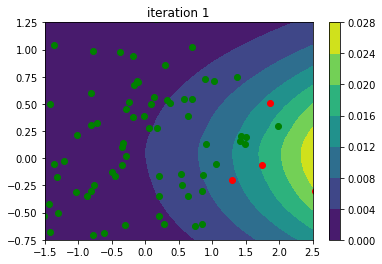

1000 1.3996154069900513


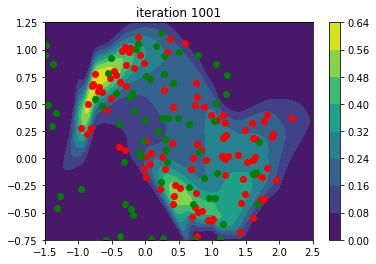

2000 1.2569248676300049


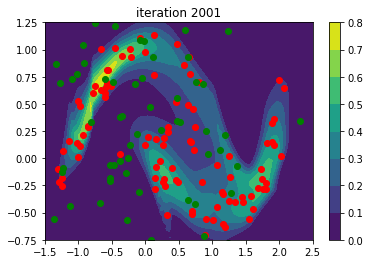

3000 1.1361711025238037


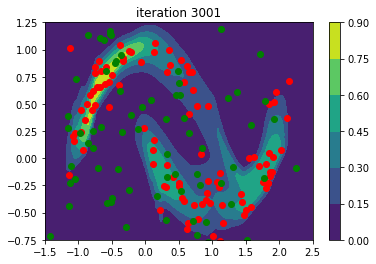

4000 1.2562469244003296


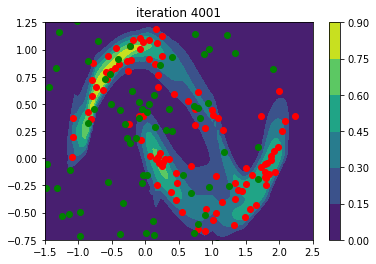

5000 1.2672771215438843


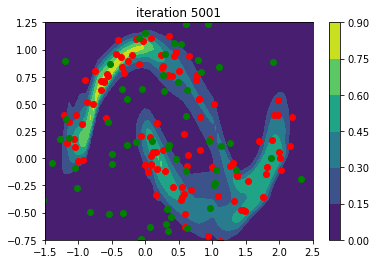

6000 1.1602129936218262


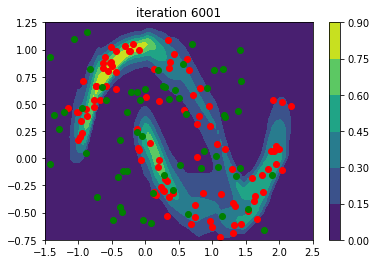

7000 1.1673927307128906


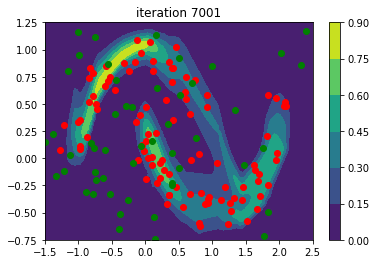

8000 1.1358722448349


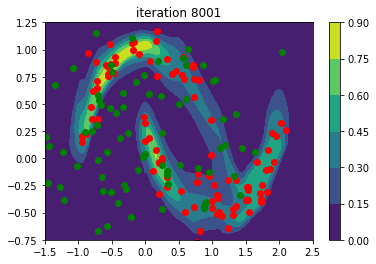

9000 1.0894651412963867


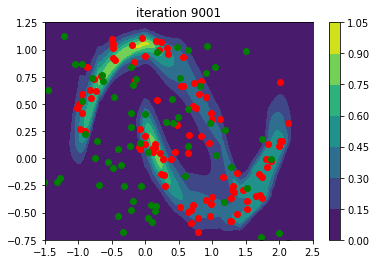

10000 1.2024439573287964


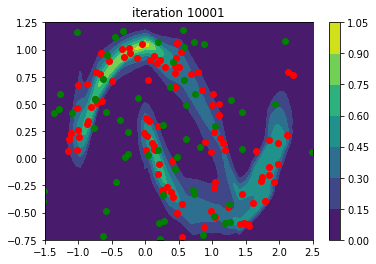

In [6]:
train_loss = train_moons(model,optimizer,base_distr="normal")

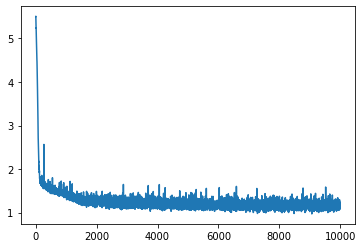

In [7]:
plt.plot(train_loss)
plt.show()

In [8]:
d = 2

shiftings = [shifting(d//2,64,d//2,3) for k in range(5)]
scalings = [shifting(d//2,64,d//2,3) for k in range(5)]

flows = []
for i in range(5):
    flows.append(DLF(scalings[i],shiftings[i],d))
    flows.append(Reverse(d))
    flows.append(BatchNorm(d))

model = NormalizingFlows(flows).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  126760


0 7.371874809265137


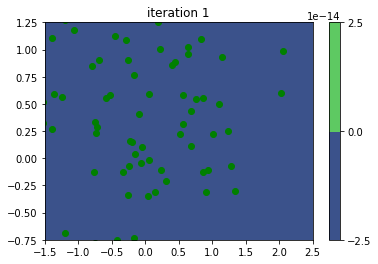

1000 5.276273727416992


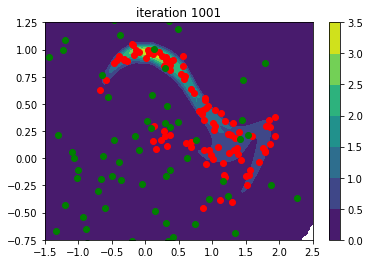

2000 4.260200500488281


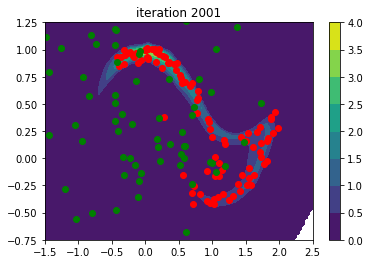

3000 3.532991886138916


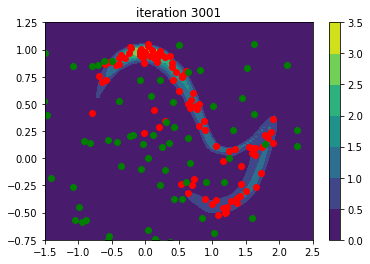

4000 2.9533143043518066


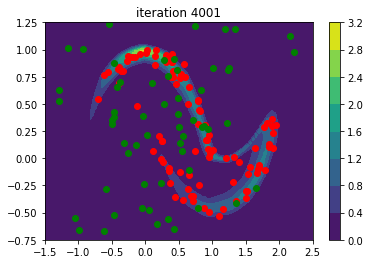

5000 2.4431498050689697


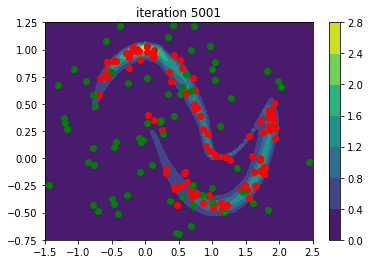

6000 1.914546251296997


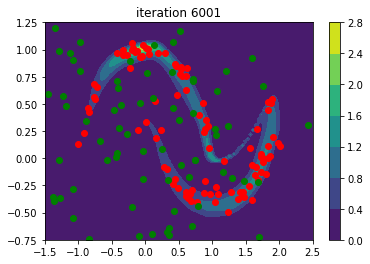

7000 1.581632137298584


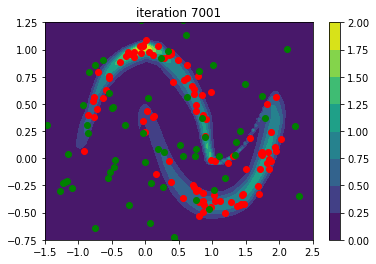

8000 1.5627574920654297


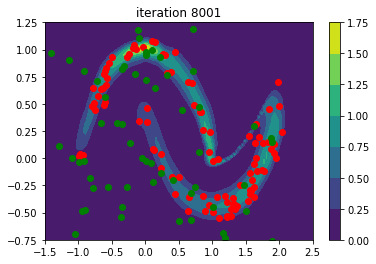

9000 1.3926551342010498


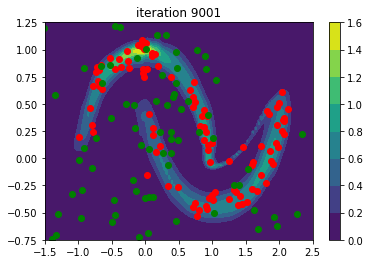

10000 1.2005023956298828


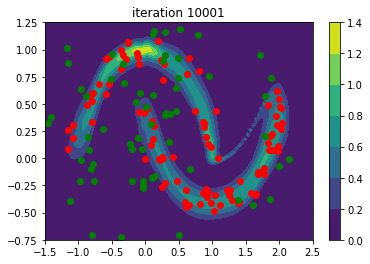

In [9]:
train_loss = train_moons(model,optimizer,base_distr="normal")

## MNIST

In [10]:
def uniform_quantization(img):
    return (img*255+torch.rand(img.size()))/256

def rescale_logit(img,lambd=1e-6):
    ## logit space
    return torch.logit(lambd+(1-2*lambd)*img)

def inverse_logit(img,lambd=1e-6):
    return (torch.sigmoid(img)-lambd)/(1-2*lambd)

In [11]:
transform = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                uniform_quantization,
                rescale_logit
                # torchvision.transforms.Normalize((0.5,), (0.5,))
    ])

train_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=True, transform=transform, download=True
)

test_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=False, transform=transform, download=True
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, shuffle=True, pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=False
)

Extracting /root/torch_datasets/MNIST/raw/train-images-idx3-ubyte.gz to /root/torch_datasets/MNIST/raw


Extracting /root/torch_datasets/MNIST/raw/train-labels-idx1-ubyte.gz to /root/torch_datasets/MNIST/raw


Extracting /root/torch_datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/torch_datasets/MNIST/raw


Extracting /root/torch_datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/torch_datasets/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


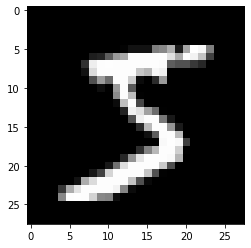

In [12]:
plt.imshow(inverse_logit(train_dataset[0][0]).reshape(28,28),"gray")
plt.show()

In [13]:
d = 784

## Add batch normalization?
shiftings = [shifting(d//2,1024,d//2,1) for k in range(5)]
scalings = [scaling(d//2,1024,d//2,1) for k in range(5)]

flows = []
for i in range(5):
    flows.append(DLF(scalings[i],shiftings[i],d))
    flows.append(Reverse(d))
    flows.append(BatchNorm(d))
    
model = NormalizingFlows(flows).to(device)

In [14]:
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  18550080


0 3449.4369830881865


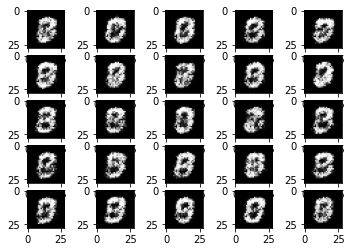

50 1192.8518724909216


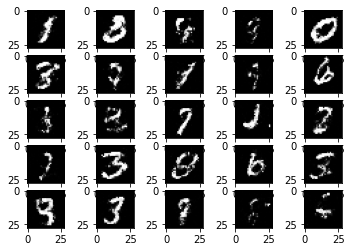

100 1163.154019679088


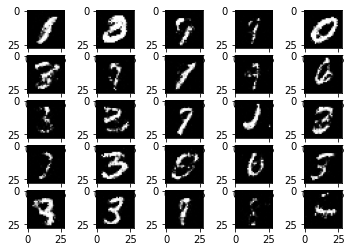

In [15]:
train_losses = train_mnist(model, optimizer, train_loader)

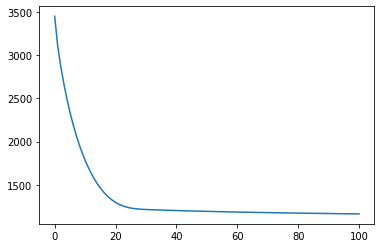

In [16]:
plt.plot(train_losses)
plt.show()

In [17]:
test_batch = []

base_distr = torch.distributions.multivariate_normal.MultivariateNormal(
    torch.zeros(d,device=device),torch.eye(d,device=device))

model.eval()

for n_batch, (data,_) in enumerate(test_loader):
    data = data.to(device)
    data = data.view(-1,28*28)
    z, log_det = model(data)

    l = log_likelihood(z[-1], log_det, base_distr)

    test_batch.append(l.mean().item())

In [18]:
# Compute the bits per dim (but irrelevant for binary data)
log_likelihood = np.mean(test_batch)
bpd = -log_likelihood / (784 * np.log(2.))
print(bpd)

2.2135046054017953


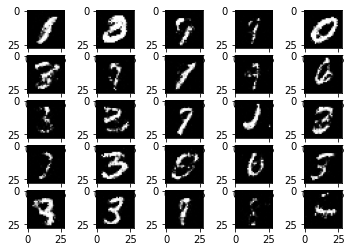

In [19]:
val_mnist(model, device)

## References

<a id="reference1"></a>

[1] Huadong Liao, Jiawei He, Kunxian Shu. Generative Model with Dynamic Linear Flow. arXiv preprint 	arXiv:1905.03239. (2019). [link](https://arxiv.org/abs/1905.03239)